In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from surprise import (accuracy, Dataset, Reader, KNNWithMeans, 
                      KNNBaseline, SVD, NormalPredictor, SlopeOne,
                      CoClustering)
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from surprise.accuracy import rmse

In [6]:
df = pd.read_csv('trail_ratings_cleaned.csv')

In [7]:
df.head()

,rate_date,rating,trail_id,user,rating_month,rating_day,rating_year,rating_time
0,"Jun 13, 2018 @ 12:43pm",5.0,trail_99253,namdoogttam,Jun,13,2018,12:43pm
1,"Aug 12, 2017 @ 2:09pm",4.0,trail_99253,WanderingMan,Aug,12,2017,2:09pm
2,"Mar 28, 2019 @ 11:46am",4.0,trail_130598,BackyardTrailsLLC,Mar,28,2019,11:46am
3,"Apr 8, 2019 @ 7:16pm",4.0,trail_140378,mtnmanpdx,Apr,8,2019,7:16pm
4,"Sep 12, 2018 @ 8:41pm",4.0,trail_140378,dylanmoore,Sep,12,2018,8:41pm


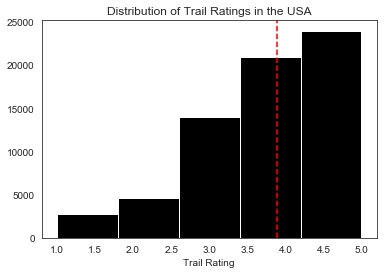

In [8]:
sns.set_style('white')
plt.hist(df['rating'], bins=5, color='k')
plt.axvline(df['rating'].mean(), color='red', ls='--')
plt.xlabel('Trail Rating')
plt.title('Distribution of Trail Ratings in the USA')
plt.show()

## Dataset Statistics

In [9]:
print('Total number of unique users: {}'.format(df.user.nunique()))
print('Total number of unique trails: {}'.format(df.trail_id.nunique()))
print('Total number of ratings: {}'.format(len(df)))
print('Average rating for the whole dataset: {:.2f}'.format(df['rating'].mean()))

Total number of unique users: 10992
Total number of unique trails: 24730
Total number of ratings: 66327
Average rating for the whole dataset: 3.89


In [10]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df[['user', 'trail_id', 'rating']], reader)

In [30]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=354)

## Algorithm & Similarity Comparisons

In [129]:
#most basic prediction algorithm, predicts random rating based on training
#distribution which is assumed normal
algo = NormalPredictor()
algo.fit(trainset)

pred = algo.test(testset)
print('Normal Predictor performance:')
print('RMSE: ', rmse(pred, verbose=False))

Normal Predictor performance:
RMSE:  1.4651772794207456


In [40]:
sim_name = ['cosine', 'msd', 'pearson', 'pearson_baseline']

for sim in sim_name:
    
    sim_options = {
        'name':sim,
        'min_support':1,
        'user_based':False
    }
    
    algo = KNNWithMeans(k=100, min_k=2, sim_options=sim_options)
    algo.fit(trainset)
    pred = algo.test(testset)
    
    print('{}_similarity for KNN Means'.format(sim))
    rmse(pred)
    print('/n')
    
    if sim == 'pearson_baseline':
        sim_options = {
            'name':sim,
            'min_support':1,
            'user_based':False,
            'shrinkage':0
        }
    
        algo = KNNBaseline(k=100, min_k=2, sim_options=sim_options)
        algo.fit(trainset)
        pred = algo.test(testset)
    
        print('{}_similarity for KNN Baseline'.format(sim))
        rmse(pred)
        print('/n')

Computing the cosine similarity matrix...
Done computing similarity matrix.
cosine_similarity for KNN Means
RMSE: 1.0680
/n
Computing the msd similarity matrix...
Done computing similarity matrix.
msd_similarity for KNN Means
RMSE: 1.0646
/n
Computing the pearson similarity matrix...
Done computing similarity matrix.
pearson_similarity for KNN Means
RMSE: 1.1007
/n
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
pearson_baseline_similarity for KNN Means
RMSE: 1.0942
/n
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
pearson_baseline_similarity for KNN Baseline
RMSE: 0.9664
/n


In [50]:
bsl_options = {
    'method':'sgd',
    'reg':0.2,
    'learning_rate':0.002,
    'n_epochs':50
} 

sim_options = {
    'name':'pearson_baseline',
    'min_support':1,
    'user_based':False,
    'shrinkage':100
}

algo = KNNBaseline(k=100, min_k=2, sim_options=sim_options, bsl_options=bsl_options)
algo.fit(trainset)

pred = algo.test(testset)
rmse(pred)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9583


0.9583076201096898

In [131]:
algo = SlopeOne()
algo.fit(trainset)
pred = algo.test(testset)
print('SlopeOne RMSE performance:\n{}'.format(rmse(pred, verbose=False)))

SlopeOne RMSE performance:
1.0777394683809434


In [137]:
# this algorithm assigns clusters to users and items seperately and
# then assigns clusters to user item pairs, means of the clusters
algo = CoClustering(
    n_cltr_u=3,
    n_cltr_i=3,
    n_epochs=50,
    random_state=654
)
algo.fit(trainset)
pred = algo.test(testset)

print('CoClustering RMSE performance:\n{}'.format(rmse(pred, verbose=False)))

CoClustering RMSE performance:
1.0801751982772625


Performance for CoClustering is on par with KNNWithMeans and SlopeOne. This algorithm is interesting because as the number of clusters decrease the RMSE also decreases, which might indicate that further clustering of the users and items outside of 1 big cluster introduces bias. It could be that the data itself is too sparse for this application.

In [55]:
# first iteration set lr and reg to be same as final point from KNNBaseline
# will iterate from there and determine more optimal numbers to compare
algo = SVD(
    n_factors=100, 
    n_epochs=50,
    lr_all=0.002,
    reg_all=0.2,
    random_state=654, 
    verbose=True
)

algo.fit(trainset)

pred = algo.test(testset)
rmse(pred)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 0.98

0.9875977681971287

The SVD algorithm is performing on par with semi-tuned KNNBaseline. From here I want to test a couple of parameter changes and then tune the SVD algorithm with GridSearchCV. If RMSE can get below the KNNBaseline RMSE above, this will be the algorithm I go with.

In [107]:
# testing with far fewer factors, lower regularization, and increased learning rate
algo = SVD(
    n_factors=500, 
    n_epochs=75,
    lr_all=0.002,
    reg_all=0.2,
    random_state=654
)

algo.fit(trainset)

pred = algo.test(testset)
print('SVD RMSE performance:\n{}'.format(rmse(pred, verbose=False)))

SVD RMSE performance:
1.012011159059524


In [127]:
# testing with far fewer factors, lower regularization, and increased learning rate
algo = SVD(
    n_factors=5, 
    n_epochs=50,
    lr_all=0.005,
    reg_all=0.056,
    random_state=654
)

algo.fit(trainset)

pred = algo.test(testset)
print('SVD RMSE performance:\n{}'.format(rmse(pred, verbose=False)))

SVD RMSE performance:
0.9398378908359813


Dropping the number of factors, increasing the learning rate, and decreasing regularization have all combined to decrease RMSE by 0.0478 to 0.9398. This will be helpful to dictate the range of parameters to use when tuning.

From here I want to tune the SVD model and do a 5-fold cv to evaluate any overfit issues. If at any point from here on performance is degrading, we will go back to tune and evaluate the KNNBaseline algorithm.

## Parameter Tuning and CV

In [14]:
param_grid = {
    'n_factors':[1,5,10,100],
    'n_epochs':[10, 50],
    'lr_all':[0.001,0.003,0.005,0.007],
    'reg_all':[0.01,0.03,0.05,0.07]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9237777049458815
{'n_factors': 1, 'n_epochs': 50, 'lr_all': 0.007, 'reg_all': 0.05}


In [21]:
algo = SVD(n_factors=1, n_epochs=50, lr_all=0.007, reg_all=0.05)
cross_validate(algo, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9314  0.9296  0.9222  0.9190  0.9271  0.9259  0.0046  
MAE (testset)     0.7030  0.7014  0.6981  0.6926  0.6978  0.6986  0.0036  
Fit time          1.92    1.76    1.76    1.75    1.76    1.79    0.07    
Test time         0.07    0.07    0.07    0.14    0.07    0.08    0.03    


{'test_rmse': array([0.93139836, 0.92957066, 0.92220211, 0.91902002, 0.92706704]),
 'test_mae': array([0.70296432, 0.70137344, 0.69807216, 0.69258124, 0.69780535]),
 'fit_time': (1.9203078746795654,
  1.7555139064788818,
  1.763383150100708,
  1.7504069805145264,
  1.758100986480713),
 'test_time': (0.0672311782836914,
  0.06780862808227539,
  0.06926417350769043,
  0.13796186447143555,
  0.06724810600280762)}

Overfit isn't a concern here. The RMSE and MAE are consistently grouped tightly around 0.92 and 0.70 respectively. This looks to be the winning model from a prediction performance perspective. The above parameters will be used in the production models comparing the SVD approach to a content based system.